<a href="https://colab.research.google.com/github/jaramillooo/autoencoder_denoising/blob/main/Denoising_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objetivos:
Comprender los principios fundamentales de los autoencoders y su aplicación en deep learning generativo.
Implementar un autoencoder básico y variacionales para una tarea específica, como reducción de dimensión, denoising o generación de imágenes.
Analizar el rendimiento y las características de las representaciones aprendidas por los autoencoders.

Esta es la propuesta que generé por el tiempo, pero tuve otra propuesta anterior dado que consideró que es muy simple esta.
Tengo el audio de unos amigos que hacen música, sin embargo me pasaron unos samples de sus audios y la idea era meterles ruido para reconstruirlos con el autoencoder, sin embargo tenían frecuencias muy bajas y los modelos no se comportaron bien, al igual que para generar la transformación de fourier no se podía por este error, opté por cambiar el proyecto e hice este con por el limitado.



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense,Dropout
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

Loads the Fashion-MNIST dataset.

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

The classes are:

Label	Description:

-	T-shirt/top
-	Trouser
-	Pullover
-	Dress
-	Coat
-	Sandal
-	Shirt
-	Sneaker
-	Bag
-	Ankle boot

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
X_train.shape

4422102/4422102 [==============================] - 1s 0us/step


(60000, 28, 28)

In [3]:
# se hace el reshape de multiplicar 28*28 para entrada del modelo
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)


In [13]:
X_train.shape,X_test.shape

((60000, 784), (10000, 784))

# Model

In [5]:

# aquí se añade el ruido, se multiplican los pixeles por .2 y posterior se añade rango de 0-1
noise_factor = 0.3

X_train_noisy = X_train + noise_factor * np.random.normal(size = X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(size = X_test.shape)

In [6]:
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

np.max(X_train_noisy)

1.0

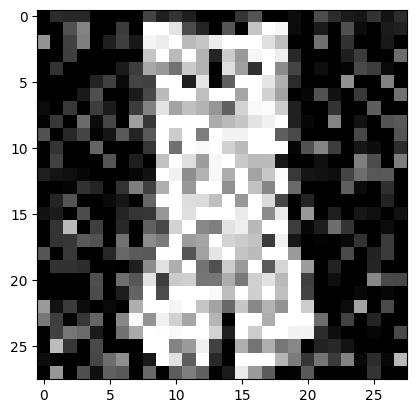

In [16]:
plt.imshow(X_train_noisy[4].reshape(28,28), cmap="gray")

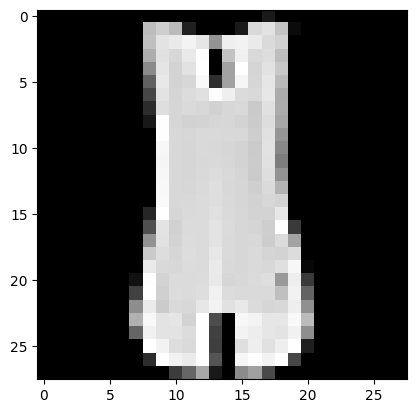

In [20]:
plt.imshow(X_train[4].reshape(28,28), cmap="gray")

# Denoising Model

In [8]:
encoding_dim = 64

input_img = Input(shape = (784, ))
encoded = Dense(128, activation = "relu")(input_img)
encoded = Dense(254, activation = "relu")(encoded)

encoded = Dense(512, activation = "relu")(encoded)
encoded = Dense(encoding_dim, activation = "relu")(encoded)

decoded = Dropout(0.1)(encoded)
decoded = Dense(128, activation = "tanh")(encoded)

decoded = Dense(512, activation = "tanh")(encoded)
decoded = Dense(784, activation = "sigmoid")(decoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

decoded_layer1 = autoencoder.layers[-2]
decoded_layer2 = autoencoder.layers[-1]
encoded_input = Input(shape=(encoding_dim,))
decoder = Model(encoded_input, decoded_layer2(decoded_layer1(encoded_input)) )

autoencoder.compile(optimizer = "adam", loss = "binary_crossentropy")

autoencoder.fit(
    X_train_noisy,
    X_train,
    epochs = 50,
    validation_data = (X_test_noisy, X_test)
)


Epoch 1/50
1875/1875 [==============================] - 12s 4ms/step - loss: 0.3236 - val_loss: 0.3043
Epoch 2/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2968 - val_loss: 0.2949
Epoch 3/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2905 - val_loss: 0.2919
Epoch 4/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2872 - val_loss: 0.2886
Epoch 5/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2852 - val_loss: 0.2873
Epoch 6/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2837 - val_loss: 0.2861
Epoch 7/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2826 - val_loss: 0.2852
Epoch 8/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2818 - val_loss: 0.2845
Epoch 9/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2810 - val_loss: 0.2846
Epoch 10/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.28

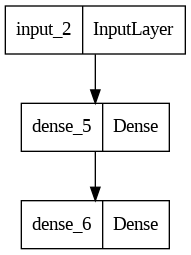

In [51]:
from tensorflow.keras.utils import plot_model
plot_model(decoder)

In [53]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 254)               32766     
                                                                 
 dense_2 (Dense)             (None, 512)               130560    
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
Total params: 296638 (1.13 MB)
Trainable params: 296638 (1.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
encoded_images = encoder.predict(X_test_noisy)
predicted_images = decoder.predict(encoded_images)

313/313 [==============================] - 1s 1ms/step


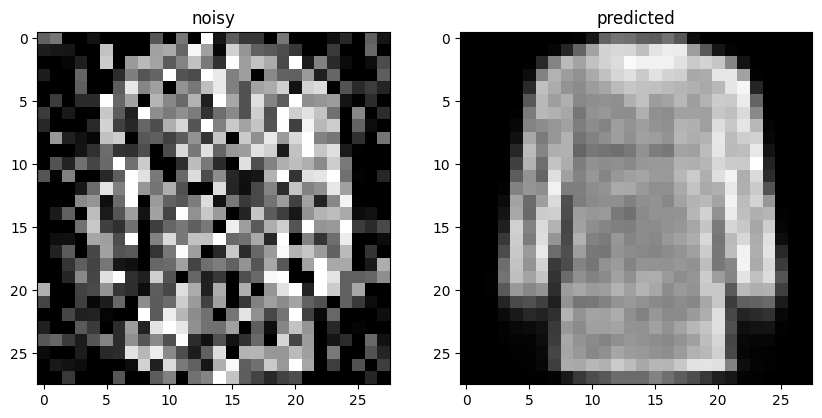

In [26]:
f = plt.figure(figsize = (10, 10))
f.add_subplot(1, 2, 1)
plt.title("noisy")
plt.imshow(X_test_noisy[4].reshape(28, 28), cmap="gray")

f.add_subplot(1, 2, 2)
plt.title("predicted")
plt.imshow(predicted_images[4].reshape(28, 28), cmap="gray")

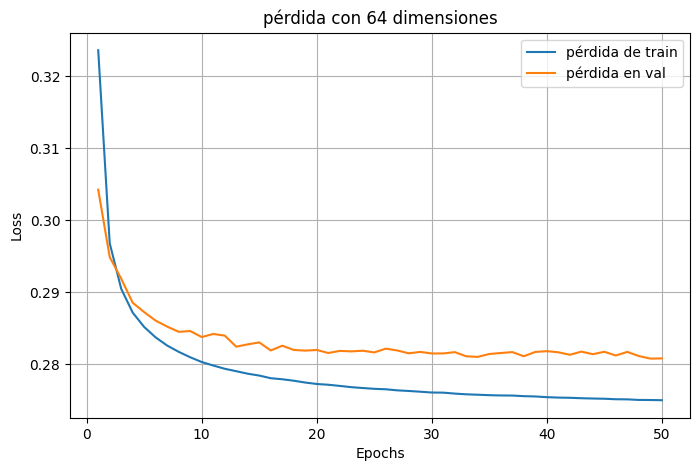

In [11]:
loss_history = autoencoder.history.history['loss']
val_loss_history = autoencoder.history.history['val_loss']

epochs = range(1, len(loss_history) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_history, label='pérdida de train')
plt.plot(epochs, val_loss_history, label='pérdida en val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('pérdida con 64 dimensiones')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()

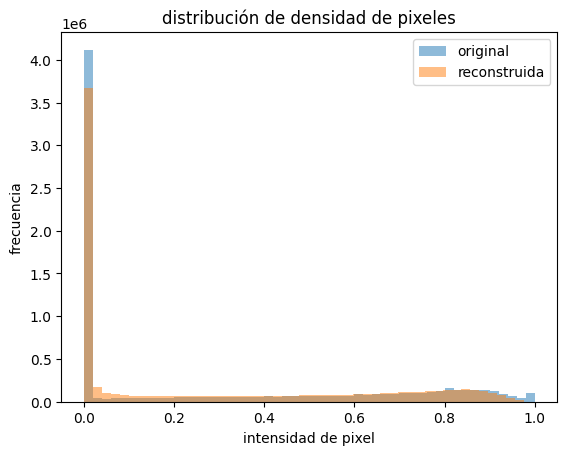

In [44]:
original_flattened = X_test.flatten()
reconstructed_flattened = predicted_images.flatten()

plt.hist(original_flattened, bins=50, label='original', alpha=0.5)
plt.hist(reconstructed_flattened, bins=50, label='reconstruida', alpha=0.5)
plt.xlabel('intensidad de pixel')
plt.ylabel('frecuencia')
plt.title('distribución de densidad de pixeles')
plt.legend()
plt.show()

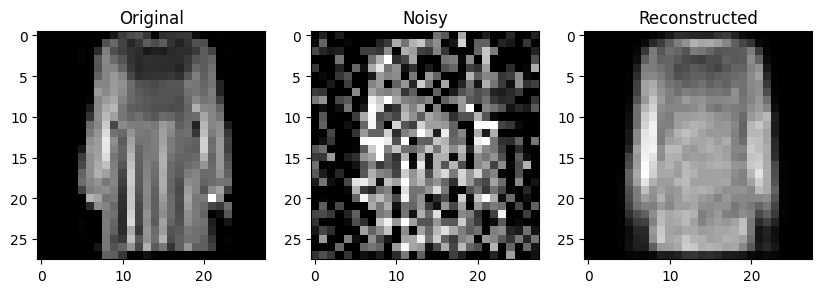

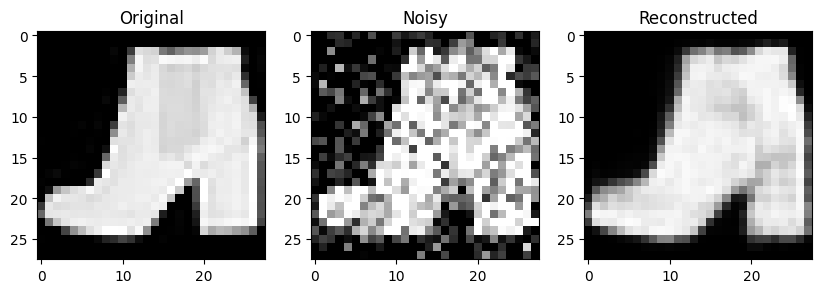

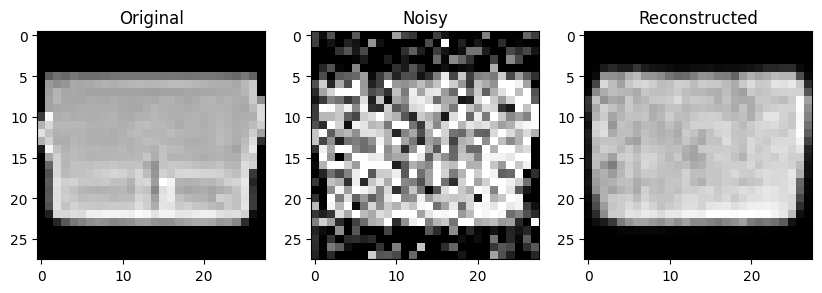

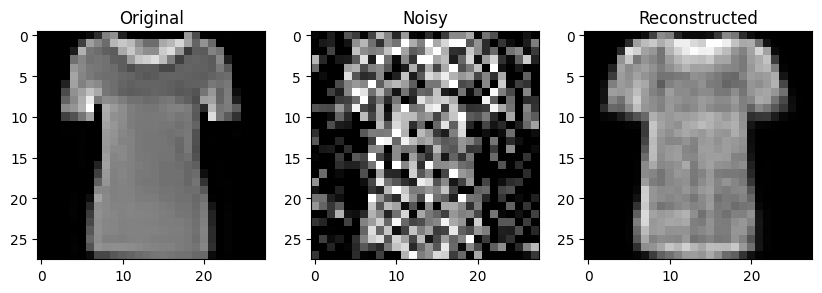

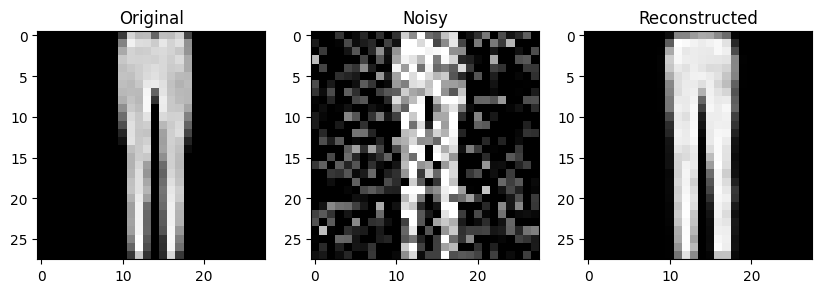

In [37]:
import matplotlib.pyplot as plt

# Select random image indices
image_indices = np.random.randint(0, X_test.shape[0], size=5)

for i in image_indices:
  original = X_test[i].reshape(28,28)
  noisy = X_test_noisy[i].reshape(28,28)
  reconstructed = predicted_images[i].reshape(28,28)

  # Normalize pixel values (if necessary)
  original = (original - original.min()) / (original.max() - original.min())
  noisy = (noisy - noisy.min()) / (noisy.max() - noisy.min())
  reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min())

  plt.figure(figsize=(10, 3))
  plt.subplot(131)
  plt.imshow(original, cmap='gray')
  plt.title('Original')
  plt.subplot(132)
  plt.imshow(noisy, cmap='gray')
  plt.title('Noisy')
  plt.subplot(133)
  plt.imshow(reconstructed, cmap='gray')
  plt.title('Reconstructed')
  plt.show()
